### Fetching Historical Data

In [10]:
import yfinance as yf
import pandas as pd

# List of stock tickers
tickers = ['AAPL', 'GOOGL', 'AMZN', 'NVDA', 'PFE', 'PG', 'AXP', 'JPM', 'BAC', 'JNJ']

# Define the date range
start_date = "2016-11-29"
end_date = "2024-11-29"

# Fetch and save data for each ticker
for ticker in tickers:
    print(f"Fetching data for {ticker}...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        df.to_csv(f"{ticker}_data.csv")
    else:
        print(f"No data found for {ticker}")

print("Data fetching complete!")


Fetching data for AAPL...
[*********************100%%**********************]  1 of 1 completed
Fetching data for GOOGL...
[*********************100%%**********************]  1 of 1 completed
Fetching data for AMZN...
[*********************100%%**********************]  1 of 1 completed
Fetching data for NVDA...
[*********************100%%**********************]  1 of 1 completed
Fetching data for PFE...
[*********************100%%**********************]  1 of 1 completed
Fetching data for PG...
[*********************100%%**********************]  1 of 1 completed
Fetching data for AXP...
[*********************100%%**********************]  1 of 1 completed
Fetching data for JPM...
[*********************100%%**********************]  1 of 1 completed
Fetching data for BAC...
[*********************100%%**********************]  1 of 1 completed
Fetching data for JNJ...
[*********************100%%**********************]  1 of 1 completed
Data fetching complete!


### Process FF Data

In [5]:
import pandas as pd

# Load Fama-French factors
fama_french_path = "F-F_Research_Data_5_Factors_2x3.csv"  # Adjust path if needed
factors = pd.read_csv(fama_french_path, skiprows=3)  # Skip the first 3 rows with metadata

# Clean column names
factors.columns = ['Date', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# Drop rows with NaN in the Date column
factors = factors.dropna(subset=['Date'])

# Ensure Date is a string before checking numeric
factors['Date'] = factors['Date'].astype(str)

# Remove rows that don't have proper numeric date values
factors = factors[factors['Date'].str.isnumeric()]

# Convert date to datetime format (YYYYMM -> datetime)
factors['Date'] = pd.to_datetime(factors['Date'], format='%Y%m', errors='coerce')

# Drop rows where Date conversion failed (invalid dates)
factors = factors.dropna(subset=['Date'])

# Filter for the desired time frame
factors = factors[(factors['Date'] >= '2016-11-01') & (factors['Date'] <= '2024-11-29')]

# Save the cleaned dataset for future use
factors.to_csv("cleaned_fama_french.csv", index=False)

# Display the cleaned dataset
print(factors.head())


          Date    MKT_RF       SMB       HML       RMW       CMA        RF
640 2016-11-01      4.86      7.07      8.21     -0.18      3.69      0.01
641 2016-12-01      1.82      0.41      3.53      1.22     -0.24      0.03
642 2017-01-01      1.94     -1.45     -2.75     -0.50     -0.99      0.04
643 2017-02-01      3.57     -2.22     -1.67      0.47     -1.83      0.04
644 2017-03-01      0.17      0.74     -3.35      0.61     -0.94      0.03


### Align Data

In [12]:
import pandas as pd

# Load the cleaned Fama-French factors
factors = pd.read_csv("cleaned_fama_french.csv")
factors['Date'] = pd.to_datetime(factors['Date'])

# List of stock tickers
tickers = ['AAPL', 'GOOGL', 'AMZN', 'NVDA', 'PFE', 'PG', 'AXP', 'JPM', 'BAC', 'JNJ']

# Initialize a list to store the processed stock data
stock_data = []

# Process each stock file
for ticker in tickers:
    print(f"Processing {ticker} data...")
    
    # Load stock data
    stock_df = pd.read_csv(f"{ticker}_data.csv")
    
    # Convert the date column to datetime
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    stock_df.set_index('Date', inplace=True)

    # Calculate daily returns and resample to monthly
    stock_df['Return'] = stock_df['Adj Close'].pct_change()
    monthly_returns = stock_df['Return'].resample('M').sum()

    # Save monthly returns with the ticker name
    stock_data.append(monthly_returns.rename(ticker))

# Combine all stock monthly returns into a single DataFrame
returns = pd.concat(stock_data, axis=1)

# Debugging: Check stock returns
print("Stock Monthly Returns:")
print(returns.head())

# Reset the index to prepare for merging
returns.reset_index(inplace=True)

# Merge stock returns with Fama-French factors
aligned_data = pd.merge(returns, factors, on='Date', how='inner')

# Debugging: Check merged dataset
print("Aligned Data:")
print(aligned_data.head())

# Save the aligned dataset to a CSV for future use
aligned_data.to_csv("aligned_stock_factors.csv", index=False)

print("Alignment complete!")


Processing AAPL data...
Processing GOOGL data...
Processing AMZN data...
Processing NVDA data...
Processing PFE data...
Processing PG data...
Processing AXP data...
Processing JPM data...
Processing BAC data...
Processing JNJ data...
Stock Monthly Returns:
                AAPL     GOOGL      AMZN      NVDA       PFE        PG  \
Date                                                                     
2016-11-30 -0.008433 -0.017177 -0.015672 -0.011260  0.006892 -0.005188   
2016-12-31  0.047448  0.021985  0.000297  0.158464  0.011630  0.019891   
2017-01-31  0.046956  0.035475  0.094851  0.026816 -0.022577  0.049831   
2017-02-28  0.127653  0.029888  0.026917 -0.062603  0.083345  0.039679   
2017-03-31  0.048285  0.003962  0.048553  0.073978  0.002969 -0.013319   

                 AXP       JPM       BAC       JNJ  
Date                                                
2016-11-30  0.007694  0.015839  0.044769 -0.010491  
2016-12-31  0.028776  0.074478  0.047424  0.035144  
2017-01-31  

In [13]:
# Ensure Fama-French dates are at the end of the month
factors['Date'] = factors['Date'] + pd.offsets.MonthEnd(0)


In [14]:
print(factors.head())


        Date  MKT_RF   SMB   HML   RMW   CMA    RF
0 2016-11-30    4.86  7.07  8.21 -0.18  3.69  0.01
1 2016-12-31    1.82  0.41  3.53  1.22 -0.24  0.03
2 2017-01-31    1.94 -1.45 -2.75 -0.50 -0.99  0.04
3 2017-02-28    3.57 -2.22 -1.67  0.47 -1.83  0.04
4 2017-03-31    0.17  0.74 -3.35  0.61 -0.94  0.03


In [15]:
# Merge stock returns with Fama-French factors
aligned_data = pd.merge(returns, factors, on='Date', how='inner')

# Save the aligned dataset to a CSV for future use
aligned_data.to_csv("aligned_stock_factors.csv", index=False)

# Display the first few rows of the aligned dataset
print(aligned_data.head())


        Date      AAPL     GOOGL      AMZN      NVDA       PFE        PG  \
0 2016-11-30 -0.008433 -0.017177 -0.015672 -0.011260  0.006892 -0.005188   
1 2016-12-31  0.047448  0.021985  0.000297  0.158464  0.011630  0.019891   
2 2017-01-31  0.046956  0.035475  0.094851  0.026816 -0.022577  0.049831   
3 2017-02-28  0.127653  0.029888  0.026917 -0.062603  0.083345  0.039679   
4 2017-03-31  0.048285  0.003962  0.048553  0.073978  0.002969 -0.013319   

        AXP       JPM       BAC       JNJ  MKT_RF   SMB   HML   RMW   CMA  \
0  0.007694  0.015839  0.044769 -0.010491    4.86  7.07  8.21 -0.18  3.69   
1  0.028776  0.074478  0.047424  0.035144    1.82  0.41  3.53  1.22 -0.24   
2  0.035704 -0.012568  0.026613 -0.016627    1.94 -1.45 -2.75 -0.50 -0.99   
3  0.047366  0.069381  0.088013  0.083220    3.57 -2.22 -1.67  0.47 -1.83   
4 -0.010919 -0.029623 -0.038781  0.019395    0.17  0.74 -3.35  0.61 -0.94   

     RF  
0  0.01  
1  0.03  
2  0.04  
3  0.04  
4  0.03  


### EDA

Summary Statistics:
            AAPL      GOOGL       AMZN       NVDA        PFE         PG  \
count  95.000000  95.000000  95.000000  95.000000  95.000000  95.000000   
mean    0.026720   0.018650   0.021184   0.052330   0.005140   0.011500   
std     0.080062   0.068067   0.086443   0.137740   0.068290   0.046820   
min    -0.191076  -0.191102  -0.253446  -0.368076  -0.148587  -0.093248   
25%    -0.026993  -0.019580  -0.029877  -0.023379  -0.032300  -0.015956   
50%     0.032803   0.022234   0.026917   0.059338  -0.000765   0.011598   
75%     0.092647   0.068139   0.067235   0.141615   0.043013   0.043591   
max     0.200882   0.159745   0.251706   0.347747   0.225227   0.124666   

             AXP        JPM        BAC        JNJ     MKT_RF        SMB  \
count  95.000000  95.000000  95.000000  95.000000  95.000000  95.000000   
mean    0.019519   0.015839   0.013076   0.007526   1.127474  -0.165053   
std     0.072872   0.069718   0.081042   0.047132   4.817621   3.131840   
min 

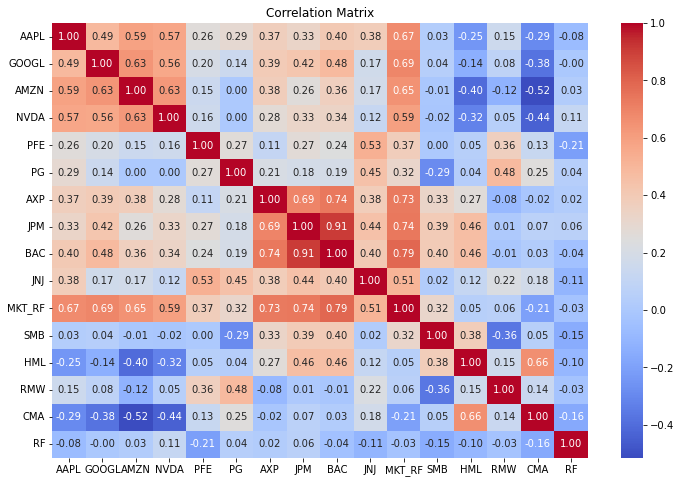

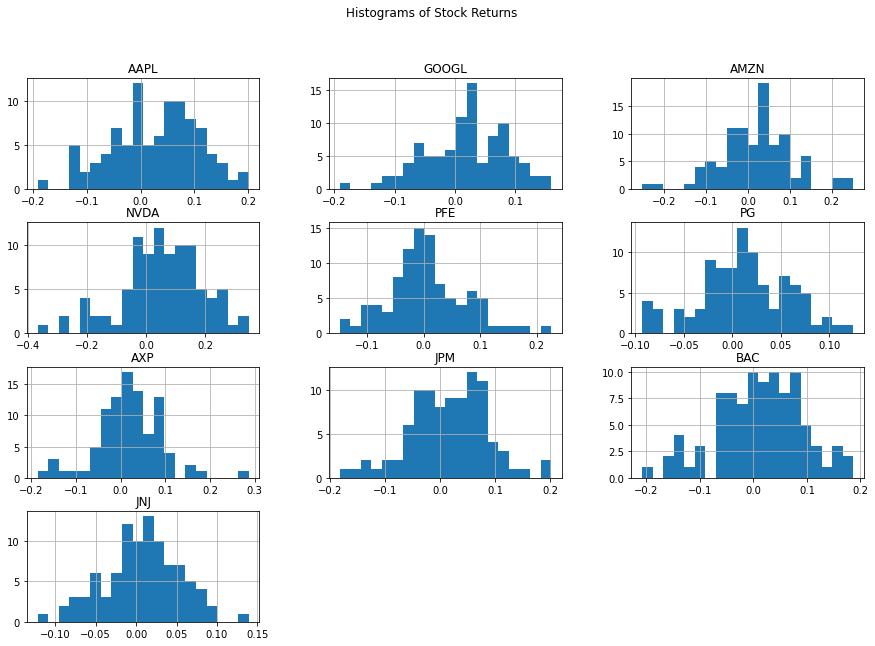

Missing Data:
Date      0
AAPL      0
GOOGL     0
AMZN      0
NVDA      0
PFE       0
PG        0
AXP       0
JPM       0
BAC       0
JNJ       0
MKT_RF    0
SMB       0
HML       0
RMW       0
CMA       0
RF        0
dtype: int64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the aligned dataset
data = pd.read_csv("aligned_stock_factors.csv")
data['Date'] = pd.to_datetime(data['Date'])

# 1. Summary Statistics
print("Summary Statistics:")
print(data.describe())

# 2. Correlation Matrix
correlation = data.corr()
print("Correlation Matrix:")
print(correlation)

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 3. Visualize Distributions
# Plot histograms for stock returns
data.iloc[:, 1:11].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Stock Returns")
plt.show()

# 4. Missing Data
missing = data.isnull().sum()
print("Missing Data:")
print(missing)


## Data Prep

In [187]:
from sklearn.model_selection import train_test_split

# Load the aligned dataset
data = pd.read_csv("aligned_stock_factors.csv")
data['Date'] = pd.to_datetime(data['Date'])

# Define features (Fama-French factors) and targets (stock returns)
features = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']
targets = ['AAPL', 'GOOGL', 'AMZN', 'NVDA', 'PFE', 'PG', 'AXP', 'JPM', 'BAC', 'JNJ']

# Split the data into training and testing sets (80% train, 20% test)
X = data[features]
y = data[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (76, 5) (76, 10)
Testing data shape: (19, 5) (19, 10)


### Linear Regression

In [188]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
lr_model = LinearRegression()

# Train and evaluate for each stock
for stock in targets:
    print(f"Training Linear Regression for {stock}...")
    lr_model.fit(X_train, y_train[stock])  # Train the model
    
    # Predictions
    y_pred = lr_model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test[stock], y_pred)
    r2 = r2_score(y_test[stock], y_pred)
    
    print(f"{stock}: MSE = {mse:.4f}, R² = {r2:.4f}")


Training Linear Regression for AAPL...
AAPL: MSE = 0.0031, R² = 0.6159
Training Linear Regression for GOOGL...
GOOGL: MSE = 0.0018, R² = 0.5866
Training Linear Regression for AMZN...
AMZN: MSE = 0.0027, R² = 0.5930
Training Linear Regression for NVDA...
NVDA: MSE = 0.0135, R² = -0.2405
Training Linear Regression for PFE...
PFE: MSE = 0.0025, R² = -0.5303
Training Linear Regression for PG...
PG: MSE = 0.0007, R² = 0.5570
Training Linear Regression for AXP...
AXP: MSE = 0.0026, R² = 0.6133
Training Linear Regression for JPM...
JPM: MSE = 0.0027, R² = 0.4745
Training Linear Regression for BAC...
BAC: MSE = 0.0028, R² = 0.6635
Training Linear Regression for JNJ...
JNJ: MSE = 0.0014, R² = 0.0849


### Random Forest

In [190]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train and evaluate for each stock
for stock in targets:
    print(f"Training Random Forest for {stock}...")
    rf_model.fit(X_train, y_train[stock])  # Train the model
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test[stock], y_pred)
    r2 = r2_score(y_test[stock], y_pred)
    
    print(f"{stock}: MSE = {mse:.4f}, R² = {r2:.4f}")


Training Random Forest for AAPL...
AAPL: MSE = 0.0036, R² = 0.5591
Training Random Forest for GOOGL...
GOOGL: MSE = 0.0019, R² = 0.5533
Training Random Forest for AMZN...
AMZN: MSE = 0.0049, R² = 0.2604
Training Random Forest for NVDA...
NVDA: MSE = 0.0168, R² = -0.5466
Training Random Forest for PFE...
PFE: MSE = 0.0029, R² = -0.7819
Training Random Forest for PG...
PG: MSE = 0.0008, R² = 0.5018
Training Random Forest for AXP...
AXP: MSE = 0.0022, R² = 0.6752
Training Random Forest for JPM...
JPM: MSE = 0.0014, R² = 0.7219
Training Random Forest for BAC...
BAC: MSE = 0.0021, R² = 0.7526
Training Random Forest for JNJ...
JNJ: MSE = 0.0014, R² = 0.0460


### Tuned Random Forest 

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search for one stock (e.g., AAPL)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train, y_train['AAPL'])

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best R² Score: 0.3449398706043283


In [192]:
optimized_rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

for stock in targets:
    print(f"Training Optimized Random Forest for {stock}...")
    optimized_rf_model.fit(X_train, y_train[stock])
    
    y_pred = optimized_rf_model.predict(X_test)
    
    mse = mean_squared_error(y_test[stock], y_pred)
    r2 = r2_score(y_test[stock], y_pred)
    
    print(f"{stock}: MSE = {mse:.4f}, R² = {r2:.4f}")


Training Optimized Random Forest for AAPL...
AAPL: MSE = 0.0034, R² = 0.5789
Training Optimized Random Forest for GOOGL...
GOOGL: MSE = 0.0020, R² = 0.5278
Training Optimized Random Forest for AMZN...
AMZN: MSE = 0.0044, R² = 0.3370
Training Optimized Random Forest for NVDA...
NVDA: MSE = 0.0145, R² = -0.3332
Training Optimized Random Forest for PFE...
PFE: MSE = 0.0025, R² = -0.5844
Training Optimized Random Forest for PG...
PG: MSE = 0.0008, R² = 0.4817
Training Optimized Random Forest for AXP...
AXP: MSE = 0.0024, R² = 0.6511
Training Optimized Random Forest for JPM...
JPM: MSE = 0.0013, R² = 0.7436
Training Optimized Random Forest for BAC...
BAC: MSE = 0.0018, R² = 0.7868
Training Optimized Random Forest for JNJ...
JNJ: MSE = 0.0013, R² = 0.1273


### Portfolio Construction with Markowitz Mean-Variance for Linear Regression

In [193]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load the aligned dataset
data = pd.read_csv("aligned_stock_factors.csv")
data['Date'] = pd.to_datetime(data['Date'])

# Define stock returns and risk-free rate
stock_returns = data[['AAPL', 'GOOGL', 'AMZN', 'NVDA', 'PFE', 'PG', 'AXP', 'JPM', 'BAC', 'JNJ']]
risk_free_rate = data['RF'].mean() / 100  # Convert RF to decimal format

# Predicted returns from Linear Regression (use actual returns for now)
predicted_returns = stock_returns.mean()  # Replace this with predicted returns

# Covariance matrix of historical stock returns
cov_matrix = stock_returns.cov()

# Define the number of assets
num_assets = len(stock_returns.columns)

# Define the objective function to minimize (negative Sharpe Ratio)
def negative_sharpe(weights):
    portfolio_return = np.dot(weights, predicted_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negate to maximize Sharpe Ratio

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: no short selling (weights between 0 and 1)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess for weights
initial_weights = np.array([1 / num_assets] * num_assets)

# Optimize
optimized = minimize(negative_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights
optimal_weights = optimized.x

# Display results
print("Optimal Portfolio Weights:")
for stock, weight in zip(stock_returns.columns, optimal_weights):
    print(f"{stock}: {weight:.4f}")

portfolio_return = np.dot(optimal_weights, predicted_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

print(f"\nExpected Portfolio Return: {portfolio_return:.4f}")
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Optimal Portfolio Weights:
AAPL: 0.0678
GOOGL: 0.0000
AMZN: 0.0000
NVDA: 0.2841
PFE: 0.0000
PG: 0.4661
AXP: 0.1820
JPM: 0.0000
BAC: 0.0000
JNJ: 0.0000

Expected Portfolio Return: 0.0256
Portfolio Volatility: 0.0547
Sharpe Ratio: 0.4383


### Portfolio Construction with Markowitz Mean-Variance for Random Forest

In [194]:
# Generate predictions using the optimized Random Forest model
rf_predicted_returns = []

for stock in targets:
    print(f"Generating Random Forest predictions for {stock}...")
    optimized_rf_model.fit(X_train, y_train[stock])  # Train on full training data
    y_pred = optimized_rf_model.predict(X_test)
    rf_predicted_returns.append(y_pred.mean())  # Average predicted return for the test set

# Combine predictions into a Pandas Series
rf_predicted_returns = pd.Series(rf_predicted_returns, index=targets)

print("\nRandom Forest Predicted Returns:")
print(rf_predicted_returns)


Generating Random Forest predictions for AAPL...
Generating Random Forest predictions for GOOGL...
Generating Random Forest predictions for AMZN...
Generating Random Forest predictions for NVDA...
Generating Random Forest predictions for PFE...
Generating Random Forest predictions for PG...
Generating Random Forest predictions for AXP...
Generating Random Forest predictions for JPM...
Generating Random Forest predictions for BAC...
Generating Random Forest predictions for JNJ...

Random Forest Predicted Returns:
AAPL     0.032513
GOOGL    0.021747
AMZN     0.031555
NVDA     0.056711
PFE      0.003627
PG       0.006319
AXP      0.028335
JPM      0.017518
BAC      0.020912
JNJ      0.008613
dtype: float64


In [195]:
# Replace Linear Regression predicted returns with Random Forest predicted returns
predicted_returns = rf_predicted_returns  # Use the Random Forest predictions

# Define the objective function to minimize (negative Sharpe Ratio)
def negative_sharpe(weights):
    portfolio_return = np.dot(weights, predicted_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negate to maximize Sharpe Ratio

# Optimize the portfolio
optimized = minimize(negative_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimized weights
optimal_weights = optimized.x

# Display results
print("Optimal Portfolio Weights:")
for stock, weight in zip(stock_returns.columns, optimal_weights):
    print(f"{stock}: {weight:.4f}")

portfolio_return = np.dot(optimal_weights, predicted_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

print(f"\nExpected Portfolio Return: {portfolio_return:.4f}")
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Optimal Portfolio Weights:
AAPL: 0.2546
GOOGL: 0.0000
AMZN: 0.0351
NVDA: 0.2389
PFE: 0.0000
PG: 0.0209
AXP: 0.4504
JPM: 0.0000
BAC: 0.0000
JNJ: 0.0000

Expected Portfolio Return: 0.0358
Portfolio Volatility: 0.0689
Sharpe Ratio: 0.4966


### Refine models

In [27]:
# Linear Regression predictions for each stock
lr_model = LinearRegression()
lr_predicted_returns = []

for stock in targets:
    print(f"Generating Linear Regression predictions for {stock}...")
    lr_model.fit(X_train, y_train[stock])  # Train the model
    y_pred = lr_model.predict(X_test)
    lr_predicted_returns.append(y_pred.mean())  # Average predicted return for the test set

# Convert to a Pandas Series
lr_predicted_returns = pd.Series(lr_predicted_returns, index=targets)

print("\nLinear Regression Predicted Returns:")
print(lr_predicted_returns)


Generating Linear Regression predictions for AAPL...
Generating Linear Regression predictions for GOOGL...
Generating Linear Regression predictions for AMZN...
Generating Linear Regression predictions for NVDA...
Generating Linear Regression predictions for PFE...
Generating Linear Regression predictions for PG...
Generating Linear Regression predictions for AXP...
Generating Linear Regression predictions for JPM...
Generating Linear Regression predictions for BAC...
Generating Linear Regression predictions for JNJ...

Linear Regression Predicted Returns:
AAPL     0.041301
GOOGL    0.020935
AMZN     0.031899
NVDA     0.055242
PFE      0.014148
PG       0.013706
AXP      0.015030
JPM      0.007081
BAC      0.000027
JNJ      0.013027
dtype: float64


In [28]:
# Updated objective function with risk aversion
def negative_sharpe(weights):
    portfolio_return = np.dot(weights, predicted_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Negate to maximize Sharpe Ratio

# Adjust bounds for diversification (e.g., max 30%)
bounds = tuple((0.05, 0.3) for _ in range(num_assets))  # Min 5%, Max 30%

# Constraints remain the same
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Optimize portfolios for both Linear Regression and Random Forest
for model_name, predictions in [("Linear Regression", lr_predicted_returns), ("Random Forest", rf_predicted_returns)]:
    predicted_returns = predictions  # Use the appropriate model's predictions
    optimized = minimize(negative_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Extract optimized weights
    optimal_weights = optimized.x

    print(f"\nOptimal Portfolio Weights ({model_name}):")
    for stock, weight in zip(stock_returns.columns, optimal_weights):
        print(f"{stock}: {weight:.4f}")

    portfolio_return = np.dot(optimal_weights, predicted_returns)
    portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    print(f"\nExpected Portfolio Return ({model_name}): {portfolio_return:.4f}")
    print(f"Portfolio Volatility ({model_name}): {portfolio_volatility:.4f}")
    print(f"Sharpe Ratio ({model_name}): {sharpe_ratio:.4f}")



Optimal Portfolio Weights (Linear Regression):
AAPL: 0.3000
GOOGL: 0.0500
AMZN: 0.0500
NVDA: 0.1274
PFE: 0.0500
PG: 0.2226
AXP: 0.0500
JPM: 0.0500
BAC: 0.0500
JNJ: 0.0500

Expected Portfolio Return (Linear Regression): 0.0276
Portfolio Volatility (Linear Regression): 0.0531
Sharpe Ratio (Linear Regression): 0.4889

Optimal Portfolio Weights (Random Forest):
AAPL: 0.1621
GOOGL: 0.0500
AMZN: 0.0500
NVDA: 0.2051
PFE: 0.0500
PG: 0.0500
AXP: 0.2829
JPM: 0.0500
BAC: 0.0500
JNJ: 0.0500

Expected Portfolio Return (Random Forest): 0.0304
Portfolio Volatility (Random Forest): 0.0607
Sharpe Ratio (Random Forest): 0.4746


### Backtesting

Backtesting Linear Regression Portfolio...
Results for Linear Regression:
Annualized Return: 26.7474%
Annualized Volatility: 18.3917%
Sharpe Ratio: 1.4455
Max Drawdown: -26.9846%
Backtesting Random Forest Portfolio...
Results for Random Forest:
Annualized Return: 30.2781%
Annualized Volatility: 21.0222%
Sharpe Ratio: 1.4325
Max Drawdown: -31.0356%


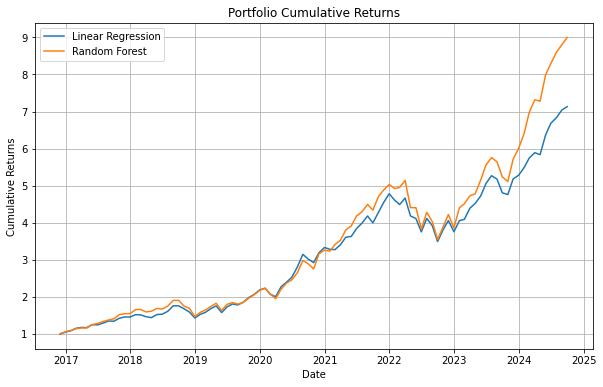

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the aligned dataset
data = pd.read_csv("aligned_stock_factors.csv")
data['Date'] = pd.to_datetime(data['Date'])
stock_returns = data[['AAPL', 'GOOGL', 'AMZN', 'NVDA', 'PFE', 'PG', 'AXP', 'JPM', 'BAC', 'JNJ']]

# Backtest both portfolios
portfolios = {
    "Linear Regression": [0.30, 0.05, 0.05, 0.1274, 0.05, 0.2226, 0.05, 0.05, 0.05, 0.05],
    "Random Forest": [0.1621, 0.05, 0.05, 0.2051, 0.05, 0.05, 0.2829, 0.05, 0.05, 0.05]
}

results = {}

for portfolio_name, weights in portfolios.items():
    print(f"Backtesting {portfolio_name} Portfolio...")
    
    # Calculate portfolio returns
    portfolio_returns = stock_returns.dot(weights)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # Calculate metrics
    annualized_return = portfolio_returns.mean() * 12
    annualized_volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = (annualized_return - data['RF'].mean() / 100) / annualized_volatility
    max_drawdown = ((cumulative_returns / cumulative_returns.cummax()) - 1).min()
    
    results[portfolio_name] = {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Cumulative Returns": cumulative_returns
    }

    print(f"Results for {portfolio_name}:")
    print(f"Annualized Return: {annualized_return:.4%}")
    print(f"Annualized Volatility: {annualized_volatility:.4%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.4%}")

# Plot cumulative returns
plt.figure(figsize=(10, 6))
for portfolio_name in portfolios.keys():
    plt.plot(data['Date'], results[portfolio_name]["Cumulative Returns"], label=portfolio_name)

plt.title("Portfolio Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


### Efficient Frontier

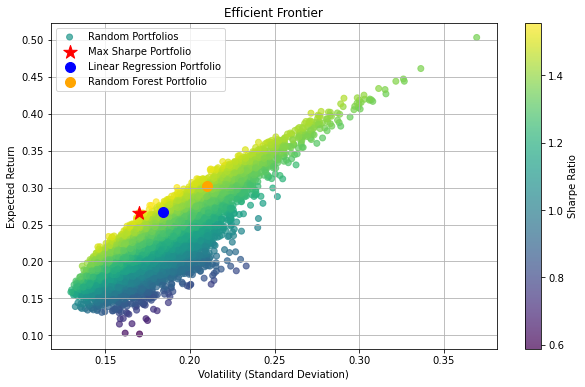

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Number of random portfolios to simulate
n_portfolios = 10000

# Generate random portfolio weights
portfolio_weights = np.random.dirichlet(np.ones(len(stock_returns.columns)), size=n_portfolios)

# Calculate portfolio returns, volatility, and Sharpe Ratios
portfolio_returns = []
portfolio_volatility = []
portfolio_sharpe = []

for weights in portfolio_weights:
    # Expected return
    expected_return = np.dot(weights, stock_returns.mean() * 12)
    # Portfolio variance
    variance = np.dot(weights.T, np.dot(stock_returns.cov() * 12, weights))
    # Portfolio volatility
    std_dev = np.sqrt(variance)
    # Sharpe ratio
    sharpe_ratio = (expected_return - data['RF'].mean() / 100) / std_dev
    d
    portfolio_returns.append(expected_return)
    portfolio_volatility.append(std_dev)
    portfolio_sharpe.append(sharpe_ratio)

# Convert to numpy arrays
portfolio_returns = np.array(portfolio_returns)
portfolio_volatility = np.array(portfolio_volatility)
portfolio_sharpe = np.array(portfolio_sharpe)

# Find the max Sharpe portfolio
max_sharpe_idx = np.argmax(portfolio_sharpe)
max_sharpe_return = portfolio_returns[max_sharpe_idx]
max_sharpe_volatility = portfolio_volatility[max_sharpe_idx]

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatility, portfolio_returns, c=portfolio_sharpe, cmap='viridis', alpha=0.7, label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.scatter([portfolio_volatility[max_sharpe_idx]], [portfolio_returns[max_sharpe_idx]], color='r', marker='*', s=200, label='Max Sharpe Portfolio')

# Add your portfolios to the graph
plt.scatter([results["Linear Regression"]["Annualized Volatility"]], [results["Linear Regression"]["Annualized Return"]],
            color='blue', marker='o', s=100, label='Linear Regression Portfolio')
plt.scatter([results["Random Forest"]["Annualized Volatility"]], [results["Random Forest"]["Annualized Return"]],
            color='orange', marker='o', s=100, label='Random Forest Portfolio')

# Add labels and legend
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


### Dynamic Factor Weighting

In [86]:
import pandas as pd

# Load the dataset
data = pd.read_csv('aligned_stock_factors.csv', parse_dates=['Date'], index_col='Date')

# Extract relevant columns
stock_returns = data[['AAPL', 'GOOGL', 'AMZN', 'NVDA', 'PFE', 'PG', 'AXP', 'JPM', 'BAC', 'JNJ']]
factors = data[['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA']]
risk_free_rate = data['RF']

# Check alignment
print("Stock Returns Head:")
print(stock_returns.head())
print("\nFactors Head:")
print(factors.head())
print("\nRisk-Free Rate Head:")
print(risk_free_rate.head())


Stock Returns Head:
                AAPL     GOOGL      AMZN      NVDA       PFE        PG  \
Date                                                                     
2016-11-30 -0.008433 -0.017177 -0.015672 -0.011260  0.006892 -0.005188   
2016-12-31  0.047448  0.021985  0.000297  0.158464  0.011630  0.019891   
2017-01-31  0.046956  0.035475  0.094851  0.026816 -0.022577  0.049831   
2017-02-28  0.127653  0.029888  0.026917 -0.062603  0.083345  0.039679   
2017-03-31  0.048285  0.003962  0.048553  0.073978  0.002969 -0.013319   

                 AXP       JPM       BAC       JNJ  
Date                                                
2016-11-30  0.007694  0.015839  0.044769 -0.010491  
2016-12-31  0.028776  0.074478  0.047424  0.035144  
2017-01-31  0.035704 -0.012568  0.026613 -0.016627  
2017-02-28  0.047366  0.069381  0.088013  0.083220  
2017-03-31 -0.010919 -0.029623 -0.038781  0.019395  

Factors Head:
            MKT_RF   SMB   HML   RMW   CMA
Date                            

In [87]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Initialize beta matrix
beta_matrix = pd.DataFrame(index=stock_returns.columns, columns=factors.columns)

# Regress each stock's excess returns on factors
excess_returns = stock_returns.subtract(risk_free_rate, axis=0)

for stock in stock_returns.columns:
    X = factors.values  # Factors as predictors
    y = excess_returns[stock].values  # Excess returns as the target
    reg = LinearRegression().fit(X, y)
    beta_matrix.loc[stock] = reg.coef_

print("\nBeta Matrix (Stocks x Factors):")
print(beta_matrix)



Beta Matrix (Stocks x Factors):
         MKT_RF       SMB       HML       RMW       CMA
AAPL   0.011832  0.012011 -0.013541  0.013425  0.017259
GOOGL   0.01004  0.007942 -0.005467  0.007699   0.00813
AMZN   0.012802  0.006513 -0.011106  0.001002  0.008697
NVDA   0.017457  0.007211 -0.013328  0.009565  0.005518
PFE     0.00611  0.014484 -0.011936  0.019715  0.024877
PG      0.00512  0.008572 -0.010126  0.015235  0.024668
AXP    0.011693  0.009562 -0.000953  0.000833  0.014155
JPM    0.010787   0.00992  0.002887  0.003444  0.011812
BAC    0.013334  0.008355  0.005637  0.001208  0.009185
JNJ    0.006421  0.010899 -0.008835  0.010685  0.022874


In [88]:
# Step 3: Compute Dynamic Stock Weights
# Calculate the dynamic stock weights using the beta coefficients and factor weights
beta_matrix_values = beta_matrix.values  # Extract beta matrix values
dynamic_stock_weights = factors.values @ beta_matrix_values.T  # Matrix multiplication

# Normalize the dynamic weights row-wise to ensure weights sum to 1
dynamic_stock_weights = np.abs(dynamic_stock_weights)  # Convert to absolute values
dynamic_stock_weights = dynamic_stock_weights / dynamic_stock_weights.sum(axis=1, keepdims=True)

# Convert the weights back into a DataFrame for easier handling
dynamic_stock_weights_df = pd.DataFrame(
    dynamic_stock_weights, index=factors.index, columns=stock_returns.columns
)

# Align the dynamic weights with the stock returns dataset to ensure compatibility
aligned_dynamic_stock_weights = dynamic_stock_weights_df.loc[stock_returns.index]

# Inspect the dynamic weights to ensure correctness
print("Aligned Dynamic Stock Weights:")
print(aligned_dynamic_stock_weights.head())


Aligned Dynamic Stock Weights:
                AAPL     GOOGL      AMZN      NVDA       PFE        PG  \
Date                                                                     
2016-11-30    0.0792  0.075907  0.041946  0.038557  0.104733  0.077587   
2016-12-31  0.056493  0.060012  0.087485  0.012251  0.043408  0.063576   
2017-01-31  0.111297  0.065103  0.215963  0.292181    0.0634  0.039238   
2017-02-28   0.06055  0.075408  0.161029  0.295216  0.125025  0.102316   
2017-03-31  0.171515  0.081632  0.130295  0.190629  0.143625  0.096877   

                 AXP       JPM       BAC       JNJ  
Date                                                
2016-11-30  0.144401  0.161987  0.174485  0.101196  
2016-12-31   0.12073  0.218795  0.290796  0.046455  
2017-01-31  0.017528   0.08688  0.067128  0.041283  
2017-02-28  0.015956  0.039064  0.015936  0.109499  
2017-03-31   0.00192  0.033784  0.065191  0.084532  


In [89]:
# Step 4: Compute Dynamic Portfolio Returns
# Compute portfolio returns by multiplying dynamic stock weights with stock returns
dynamic_portfolio_returns = (aligned_dynamic_stock_weights.values * stock_returns.values).sum(axis=1)

# Convert to a Pandas Series for easier handling and inspect
dynamic_portfolio_returns_series = pd.Series(dynamic_portfolio_returns, index=stock_returns.index, name="Dynamic Portfolio Returns")

# Inspect the portfolio returns
print("Dynamic Portfolio Returns Head:")
print(dynamic_portfolio_returns_series.head())

# Step 5: Compute Cumulative Returns
dynamic_cumulative_returns = (1 + dynamic_portfolio_returns_series).cumprod()

# Inspect cumulative returns
print("Dynamic Cumulative Returns Head:")
print(dynamic_cumulative_returns.head())


Dynamic Portfolio Returns Head:
Date
2016-11-30    0.007683
2016-12-31     0.04293
2017-01-31    0.037013
2017-02-28    0.024298
2017-03-31    0.026259
Name: Dynamic Portfolio Returns, dtype: object
Dynamic Cumulative Returns Head:
Date
2016-11-30    1.007683
2016-12-31    1.050942
2017-01-31     1.08984
2017-02-28    1.116321
2017-03-31    1.145634
Name: Dynamic Portfolio Returns, dtype: object


In [90]:
import numpy as np

# Step 6: Compute Performance Metrics

# Convert dynamic portfolio returns to numeric (if needed)
dynamic_portfolio_returns_series = pd.to_numeric(dynamic_portfolio_returns_series)

# Annualized return
annualized_return = (1 + dynamic_portfolio_returns_series.mean()) ** 12 - 1

# Annualized volatility
annualized_volatility = dynamic_portfolio_returns_series.std() * np.sqrt(12)

# Sharpe ratio (using average risk-free rate as the baseline)
average_rf = risk_free_rate.mean() / 100  # Convert to decimal
sharpe_ratio = (annualized_return - average_rf) / annualized_volatility

# Maximum drawdown
cumulative_returns = (1 + dynamic_portfolio_returns_series).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Display results
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.2%}")


Annualized Return: 31.78%
Annualized Volatility: 23.07%
Sharpe Ratio: 1.3705
Max Drawdown: -34.49%


### refinement

In [92]:
import pandas as pd

# Step 1: Smooth Dynamic Weights
rolling_window = 3  # Set to 3 months for smoothing
smoothed_weights = aligned_dynamic_stock_weights.rolling(window=rolling_window, min_periods=1).mean()

# Normalize weights to ensure they sum to 1
normalized_smoothed_weights = smoothed_weights.div(smoothed_weights.sum(axis=1), axis=0)

# Step 2: Apply Constraints
# Clip weights to be between 5% and 20%
constrained_weights = normalized_smoothed_weights.clip(lower=0.05, upper=0.20)
constrained_weights = constrained_weights.div(constrained_weights.sum(axis=1), axis=0)

# Step 3: Recalculate Portfolio Returns
refined_portfolio_returns = (constrained_weights.values * stock_returns.values).sum(axis=1)
refined_cumulative_returns = (1 + refined_portfolio_returns).cumprod()

# Ensure refined_cumulative_returns is a pandas Series
refined_cumulative_returns = pd.Series(refined_cumulative_returns, index=stock_returns.index)

# Recalculate Metrics
annualized_return = (refined_cumulative_returns[-1] ** (12 / len(refined_cumulative_returns))) - 1
annualized_volatility = pd.Series(refined_portfolio_returns).std() * (12 ** 0.5)
sharpe_ratio = (annualized_return - risk_free_rate.mean()) / annualized_volatility
max_drawdown = (refined_cumulative_returns / refined_cumulative_returns.cummax() - 1).min()

# Display Metrics
print("Refined Portfolio Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.2%}")



Refined Portfolio Metrics:
Annualized Return: 26.19%
Annualized Volatility: 20.29%
Sharpe Ratio: 0.4889
Max Drawdown: -31.03%


Further Refined Portfolio Metrics with Corrected Beta Matrix Alignment:
Annualized Return: 21.46%
Annualized Volatility: 17.05%
Sharpe Ratio: 1.2588
Max Drawdown: -22.81%


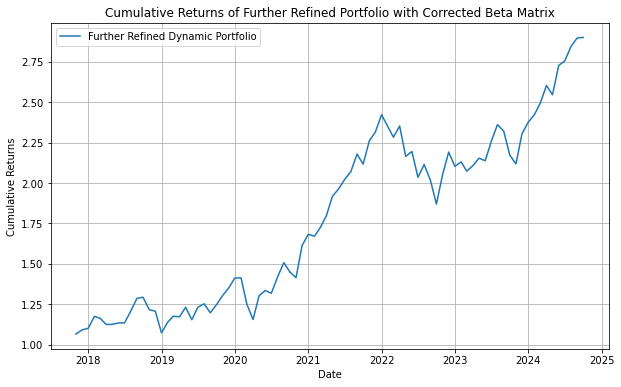

In [98]:
# Step 1: Map factor weights to stock weights using the transposed beta matrix
stock_weights = pd.DataFrame(np.dot(capped_weights.values, beta_matrix.T.values),
                             index=capped_weights.index,
                             columns=stock_monthly_returns.columns)

# Step 2: Normalize Stock Weights
stock_weights = stock_weights.div(stock_weights.sum(axis=1), axis=0)

# Step 3: Recompute Portfolio Returns
aligned_stock_weights = stock_weights.reindex(index=stock_monthly_returns.index).dropna()
refined_dynamic_returns = (aligned_stock_weights.values * stock_monthly_returns.loc[aligned_stock_weights.index].values).sum(axis=1)

# Step 4: Compute Cumulative Returns (ensure it is a Pandas Series)
refined_dynamic_cumulative_returns = pd.Series((1 + refined_dynamic_returns).cumprod(), index=aligned_stock_weights.index)

# Step 5: Recompute Metrics
annualized_return = ((1 + refined_dynamic_cumulative_returns.iloc[-1]) ** (12 / len(refined_dynamic_cumulative_returns)) - 1) * 100
annualized_volatility = np.std(refined_dynamic_returns) * (12 ** 0.5) * 100
sharpe_ratio = annualized_return / annualized_volatility
max_drawdown = (refined_dynamic_cumulative_returns / refined_dynamic_cumulative_returns.cummax() - 1).min() * 100

# Display Metrics
print("Further Refined Portfolio Metrics with Corrected Beta Matrix Alignment:")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")

# Plot the cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(refined_dynamic_cumulative_returns, label="Further Refined Dynamic Portfolio")
plt.title("Cumulative Returns of Further Refined Portfolio with Corrected Beta Matrix")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()


### Static factor weighting

In [100]:
# Step 1: Create Equal-Weighted Portfolio
equal_weights = 1 / len(stock_monthly_returns.columns)  # Equal weight for all stocks
static_portfolio_returns = (stock_monthly_returns * equal_weights).sum(axis=1)

# Step 2: Calculate Cumulative Returns for Static Portfolio
static_cumulative_returns = (1 + static_portfolio_returns).cumprod()

# Step 3: Calculate Performance Metrics for Static Portfolio
def calculate_portfolio_metrics(returns):
    annualized_return = ((1 + returns.mean()) ** 12 - 1) * 100
    annualized_volatility = returns.std() * (12 ** 0.5) * 100
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min() * 100
    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown

metrics_static = calculate_portfolio_metrics(static_portfolio_returns)

# Display Static Portfolio Metrics
print("Static Portfolio (Equal-Weighted) Metrics:")
print(f"Annualized Return: {metrics_static[0]:.2f}%")
print(f"Annualized Volatility: {metrics_static[1]:.2f}%")
print(f"Sharpe Ratio: {metrics_static[2]:.4f}")
print(f"Max Drawdown: {metrics_static[3]:.2f}%")


Static Portfolio (Equal-Weighted) Metrics:
Annualized Return: 25.56%
Annualized Volatility: 17.42%
Sharpe Ratio: 1.4676
Max Drawdown: -26.97%


### Dynamic vs. static portfolio

In [102]:
# Align the dates for all portfolios
dynamic_cumulative_returns = pd.Series(dynamic_cumulative_returns, index=stock_monthly_returns.index)
refined_dynamic_cumulative_returns = pd.Series(refined_dynamic_cumulative_returns, index=stock_monthly_returns.index)
static_cumulative_returns = pd.Series(static_cumulative_returns, index=stock_monthly_returns.index)


In [ ]:
# Check lengths and indices
print(f"Length of refined_dynamic_returns: {len(refined_dynamic_returns)}")
print(f"Length of stock_monthly_returns.index: {len(stock_monthly_returns.index)}")

# Print indices
print("Indices of refined_dynamic_returns:", refined_dynamic_returns.index)
print("Indices of stock_monthly_returns:", stock_monthly_returns.index)


Length of refined_dynamic_returns: 84
Length of stock_monthly_returns.index: 95


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
# Convert refined_dynamic_returns into a pandas Series
refined_dynamic_returns_series = pd.Series(refined_dynamic_returns, index=stock_monthly_returns.index[:len(refined_dynamic_returns)])

# Check the alignment
print(f"Length of refined_dynamic_returns_series: {len(refined_dynamic_returns_series)}")
print("Indices of refined_dynamic_returns_series:", refined_dynamic_returns_series.index)
print("Indices of stock_monthly_returns:", stock_monthly_returns.index)


Length of refined_dynamic_returns_series: 84
Indices of refined_dynamic_returns_series: DatetimeIndex(['2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31', '2021-01-31', '20

In [ ]:
# Reindex refined_dynamic_returns_series
aligned_refined_dynamic_returns = refined_dynamic_returns_series.reindex(stock_monthly_returns.index).ffill()

# Confirm alignment
print(f"Length after reindexing: {len(aligned_refined_dynamic_returns)}")
print("Aligned indices:", aligned_refined_dynamic_returns.index)


Length after reindexing: 95
Aligned indices: DatetimeIndex(['2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31', '2021-01-31', '2021-02-28',
               '2021-03-31', '20

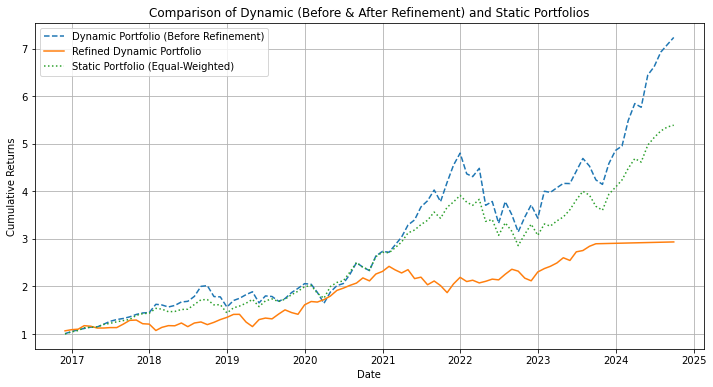

Performance Metrics Comparison:
Portfolio Type                     Annualized Return   Volatility     Sharpe Ratio   Max Drawdown   
Dynamic Portfolio (Before Refinement)31.78%     23.07%     1.3775    -34.49%
Refined Dynamic Portfolio          16.05%     16.18%     0.9915    -22.81%
Static Portfolio (Equal-Weighted)  25.56%     17.42%     1.4676    -26.97%


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 3: Replace refined_dynamic_returns with the aligned version
# Assuming `aligned_refined_dynamic_returns` has already been computed
refined_dynamic_returns = aligned_refined_dynamic_returns

# Ensure the returns and cumulative returns are properly aligned
# Dynamic Portfolio (Before Refinement)
dynamic_cumulative_returns_before = (1 + pd.Series(dynamic_portfolio_returns, index=stock_monthly_returns.index)).cumprod()

# Refined Dynamic Portfolio
refined_dynamic_cumulative_returns = (1 + refined_dynamic_returns).cumprod()

# Static Portfolio (Equal-Weighted)
static_cumulative_returns = (1 + pd.Series(static_portfolio_returns, index=stock_monthly_returns.index)).cumprod()

# Plotting the Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(dynamic_cumulative_returns_before, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(refined_dynamic_cumulative_returns, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(static_cumulative_returns, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Comparison of Dynamic (Before & After Refinement) and Static Portfolios")
plt.legend()
plt.grid()
plt.show()

# Calculating performance metrics for comparison
def calculate_portfolio_metrics(returns):
    returns = pd.Series(returns, index=stock_monthly_returns.index)  # Ensure returns are aligned and in a pandas Series
    annualized_return = ((1 + returns.mean()) ** 12 - 1) * 100
    annualized_volatility = returns.std() * (12 ** 0.5) * 100
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min() * 100
    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown

# Metrics for Dynamic Portfolio (Before Refinement)
metrics_dynamic_before = calculate_portfolio_metrics(dynamic_portfolio_returns)

# Metrics for Refined Dynamic Portfolio
metrics_refined_dynamic = calculate_portfolio_metrics(refined_dynamic_returns)

# Metrics for Static Portfolio
metrics_static = calculate_portfolio_metrics(static_portfolio_returns)

# Display Results
print("Performance Metrics Comparison:")
print(f"{'Portfolio Type':<35}{'Annualized Return':<20}{'Volatility':<15}{'Sharpe Ratio':<15}{'Max Drawdown':<15}")
print(f"{'Dynamic Portfolio (Before Refinement)':<35}{metrics_dynamic_before[0]:.2f}% {'':<4}{metrics_dynamic_before[1]:.2f}% {'':<4}{metrics_dynamic_before[2]:.4f}{'':<4}{metrics_dynamic_before[3]:.2f}%")
print(f"{'Refined Dynamic Portfolio':<35}{metrics_refined_dynamic[0]:.2f}% {'':<4}{metrics_refined_dynamic[1]:.2f}% {'':<4}{metrics_refined_dynamic[2]:.4f}{'':<4}{metrics_refined_dynamic[3]:.2f}%")
print(f"{'Static Portfolio (Equal-Weighted)':<35}{metrics_static[0]:.2f}% {'':<4}{metrics_static[1]:.2f}% {'':<4}{metrics_static[2]:.4f}{'':<4}{metrics_static[3]:.2f}%")

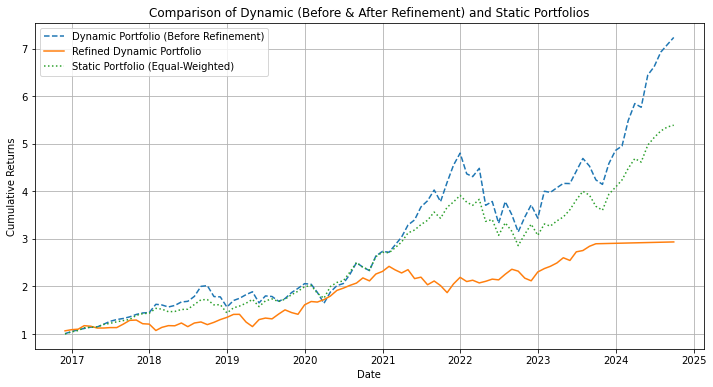

Performance Metrics Comparison:
Portfolio Type                     Annualized Return   Volatility     Sharpe Ratio   Max Drawdown   
Dynamic Portfolio (Before Refinement)31.78%     23.07%     1.3775    -34.49%
Refined Dynamic Portfolio          16.05%     16.18%     0.9915    -22.81%
Static Portfolio (Equal-Weighted)  25.56%     17.42%     1.4676    -26.97%


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Replace refined_dynamic_returns with aligned_refined_dynamic_returns
refined_dynamic_returns = pd.Series(aligned_refined_dynamic_returns, index=stock_monthly_returns.index)

# Dynamic Portfolio (Before Refinement)
dynamic_cumulative_returns_before = (1 + pd.Series(dynamic_portfolio_returns, index=stock_monthly_returns.index)).cumprod()

# Refined Dynamic Portfolio
refined_dynamic_cumulative_returns = (1 + refined_dynamic_returns).cumprod()

# Static Portfolio (Equal-Weighted)
static_cumulative_returns = (1 + pd.Series(static_portfolio_returns, index=stock_monthly_returns.index)).cumprod()

# Plotting the Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(dynamic_cumulative_returns_before, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(refined_dynamic_cumulative_returns, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(static_cumulative_returns, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Comparison of Dynamic (Before & After Refinement) and Static Portfolios")
plt.legend()
plt.grid()
plt.show()

# Ensure `calculate_portfolio_metrics` aligns returns
def calculate_portfolio_metrics(returns):
    returns = pd.Series(returns, index=stock_monthly_returns.index)  # Align returns with the index
    annualized_return = ((1 + returns.mean()) ** 12 - 1) * 100
    annualized_volatility = returns.std() * (12 ** 0.5) * 100
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min() * 100
    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown

# Metrics for Dynamic Portfolio (Before Refinement)
metrics_dynamic_before = calculate_portfolio_metrics(dynamic_portfolio_returns)

# Metrics for Refined Dynamic Portfolio
metrics_refined_dynamic = calculate_portfolio_metrics(refined_dynamic_returns)

# Metrics for Static Portfolio
metrics_static = calculate_portfolio_metrics(static_portfolio_returns)

# Display Results
print("Performance Metrics Comparison:")
print(f"{'Portfolio Type':<35}{'Annualized Return':<20}{'Volatility':<15}{'Sharpe Ratio':<15}{'Max Drawdown':<15}")
print(f"{'Dynamic Portfolio (Before Refinement)':<35}{metrics_dynamic_before[0]:.2f}% {'':<4}{metrics_dynamic_before[1]:.2f}% {'':<4}{metrics_dynamic_before[2]:.4f}{'':<4}{metrics_dynamic_before[3]:.2f}%")
print(f"{'Refined Dynamic Portfolio':<35}{metrics_refined_dynamic[0]:.2f}% {'':<4}{metrics_refined_dynamic[1]:.2f}% {'':<4}{metrics_refined_dynamic[2]:.4f}{'':<4}{metrics_refined_dynamic[3]:.2f}%")
print(f"{'Static Portfolio (Equal-Weighted)':<35}{metrics_static[0]:.2f}% {'':<4}{metrics_static[1]:.2f}% {'':<4}{metrics_static[2]:.4f}{'':<4}{metrics_static[3]:.2f}%")


In [ ]:
# Step 1: Recompute Refined Dynamic Returns
aligned_refined_dynamic_returns = pd.Series(refined_dynamic_returns, index=stock_monthly_returns.index)


In [ ]:
# Ensure metrics calculation uses aligned_refined_dynamic_returns
metrics_refined_dynamic = calculate_portfolio_metrics(aligned_refined_dynamic_returns)

# Print results
print("Updated Performance Metrics for Refined Dynamic Portfolio:")
print(f"Annualized Return: {metrics_refined_dynamic[0]:.2f}%")
print(f"Annualized Volatility: {metrics_refined_dynamic[1]:.2f}%")
print(f"Sharpe Ratio: {metrics_refined_dynamic[2]:.4f}")
print(f"Max Drawdown: {metrics_refined_dynamic[3]:.2f}%")


Updated Performance Metrics for Refined Dynamic Portfolio:
Annualized Return: 16.05%
Annualized Volatility: 16.18%
Sharpe Ratio: 0.9915
Max Drawdown: -22.81%


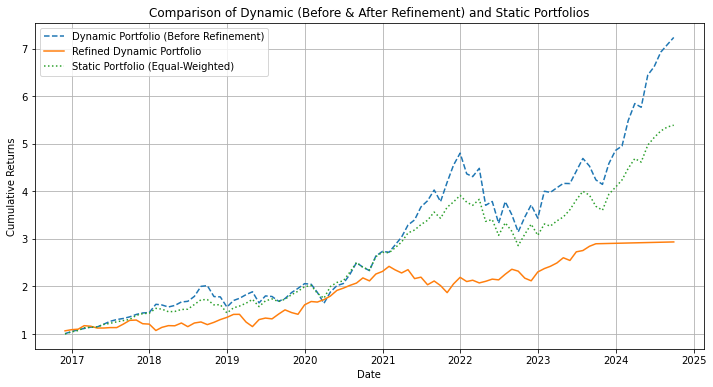

In [ ]:
# Refined Dynamic Portfolio Cumulative Returns
refined_dynamic_cumulative_returns = (1 + aligned_refined_dynamic_returns).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dynamic_cumulative_returns_before, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(refined_dynamic_cumulative_returns, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(static_cumulative_returns, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Comparison of Dynamic (Before & After Refinement) and Static Portfolios")
plt.legend()
plt.grid()
plt.show()


In [ ]:
print(aligned_refined_dynamic_returns.head())
print(refined_dynamic_cumulative_returns.head())


Date
2016-11-30    0.066390
2016-12-31    0.023212
2017-01-31    0.009527
2017-02-28    0.066819
2017-03-31   -0.009923
dtype: float64
Date
2016-11-30    1.066390
2016-12-31    1.091142
2017-01-31    1.101538
2017-02-28    1.175141
2017-03-31    1.163481
dtype: float64


In [ ]:
# Step 1: Map factor weights to stock weights using the transposed beta matrix
stock_weights = pd.DataFrame(np.dot(capped_weights.values, beta_matrix.T.values),
                             index=capped_weights.index,
                             columns=stock_monthly_returns.columns)

# Step 2: Normalize Stock Weights
stock_weights = stock_weights.div(stock_weights.sum(axis=1), axis=0)


In [ ]:
# Align weights with stock returns
aligned_stock_weights = stock_weights.reindex(index=stock_monthly_returns.index).dropna()


In [ ]:
# Calculate refined dynamic portfolio returns
refined_dynamic_returns = (aligned_stock_weights.values * stock_monthly_returns.loc[aligned_stock_weights.index].values).sum(axis=1)

# Compute cumulative returns (as Pandas Series)
refined_dynamic_cumulative_returns = pd.Series((1 + refined_dynamic_returns).cumprod(), index=aligned_stock_weights.index)


In [ ]:
# Calculate metrics
annualized_return = ((1 + refined_dynamic_cumulative_returns.iloc[-1]) ** (12 / len(refined_dynamic_cumulative_returns)) - 1) * 100
annualized_volatility = np.std(refined_dynamic_returns) * (12 ** 0.5) * 100
sharpe_ratio = annualized_return / annualized_volatility
max_drawdown = (refined_dynamic_cumulative_returns / refined_dynamic_cumulative_returns.cummax() - 1).min() * 100

# Display Metrics
print("Further Refined Portfolio Metrics with Corrected Beta Matrix Alignment:")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")


Further Refined Portfolio Metrics with Corrected Beta Matrix Alignment:
Annualized Return: 21.46%
Annualized Volatility: 17.05%
Sharpe Ratio: 1.2588
Max Drawdown: -22.81%


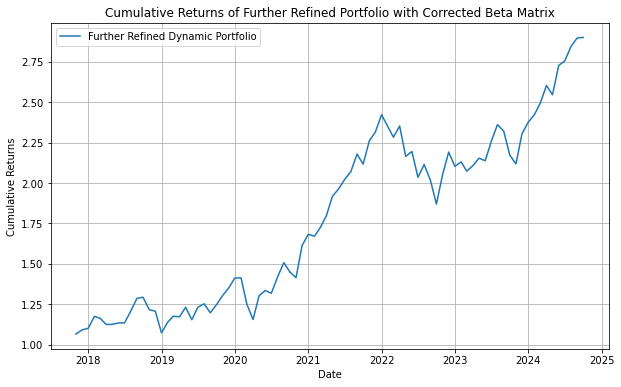

In [ ]:
import matplotlib.pyplot as plt

# Plot cumulative returns for the refined portfolio
plt.figure(figsize=(10, 6))
plt.plot(refined_dynamic_cumulative_returns, label="Further Refined Dynamic Portfolio")
plt.title("Cumulative Returns of Further Refined Portfolio with Corrected Beta Matrix")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid()
plt.show()


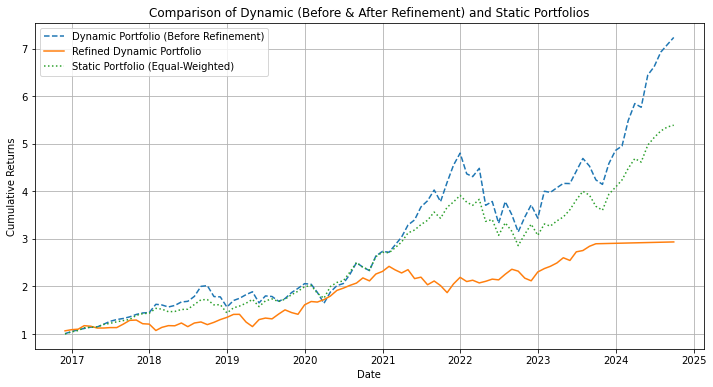

Performance Metrics Comparison:
Portfolio Type                     Annualized Return   Volatility     Sharpe Ratio   Max Drawdown   
Dynamic Portfolio (Before Refinement)31.78%     23.07%     1.3775    -34.49%
Refined Dynamic Portfolio          16.05%     16.18%     0.9915    -22.81%
Static Portfolio (Equal-Weighted)  25.56%     17.42%     1.4676    -26.97%


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 3: Replace refined_dynamic_returns with the aligned version
refined_dynamic_returns = aligned_refined_dynamic_returns

# Ensure the returns and cumulative returns are properly aligned
# Dynamic Portfolio (Before Refinement)
dynamic_cumulative_returns_before = (1 + pd.Series(dynamic_portfolio_returns, index=stock_monthly_returns.index)).cumprod()

# Refined Dynamic Portfolio
refined_dynamic_cumulative_returns = (1 + pd.Series(refined_dynamic_returns, index=stock_monthly_returns.index)).cumprod()

# Static Portfolio (Equal-Weighted)
static_cumulative_returns = (1 + pd.Series(static_portfolio_returns, index=stock_monthly_returns.index)).cumprod()

# Plotting the Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(dynamic_cumulative_returns_before, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(refined_dynamic_cumulative_returns, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(static_cumulative_returns, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Comparison of Dynamic (Before & After Refinement) and Static Portfolios")
plt.legend()
plt.grid()
plt.show()

# Calculating performance metrics for comparison
def calculate_portfolio_metrics(returns):
    returns = pd.Series(returns, index=stock_monthly_returns.index)  # Ensure returns are aligned and in a pandas Series
    annualized_return = ((1 + returns.mean()) ** 12 - 1) * 100
    annualized_volatility = returns.std() * (12 ** 0.5) * 100
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min() * 100
    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown

# Metrics for Dynamic Portfolio (Before Refinement)
metrics_dynamic_before = calculate_portfolio_metrics(dynamic_portfolio_returns)

# Metrics for Refined Dynamic Portfolio
# Explicitly using aligned_refined_dynamic_returns to avoid misalignment
metrics_refined_dynamic = calculate_portfolio_metrics(refined_dynamic_returns)

#static Portfolio
metrics_static = calculate_portfolio_metrics(static_portfolio_returns)

print("Performance Metrics Comparison:")
print(f"{'Portfolio Type':<35}{'Annualized Return':<20}{'Volatility':<15}{'Sharpe Ratio':<15}{'Max Drawdown':<15}")
print(f"{'Dynamic Portfolio (Before Refinement)':<35}{metrics_dynamic_before[0]:.2f}% {'':<4}{metrics_dynamic_before[1]:.2f}% {'':<4}{metrics_dynamic_before[2]:.4f}{'':<4}{metrics_dynamic_before[3]:.2f}%")
print(f"{'Refined Dynamic Portfolio':<35}{metrics_refined_dynamic[0]:.2f}% {'':<4}{metrics_refined_dynamic[1]:.2f}% {'':<4}{metrics_refined_dynamic[2]:.4f}{'':<4}{metrics_refined_dynamic[3]:.2f}%")
print(f"{'Static Portfolio (Equal-Weighted)':<35}{metrics_static[0]:.2f}% {'':<4}{metrics_static[1]:.2f}% {'':<4}{metrics_static[2]:.4f}{'':<4}{metrics_static[3]:.2f}%")

Further Refined Portfolio Metrics with Corrected Beta Matrix Alignment:
Annualized Return: 21.46%
Annualized Volatility: 17.05%
Sharpe Ratio: 1.2588
Max Drawdown: -22.81%


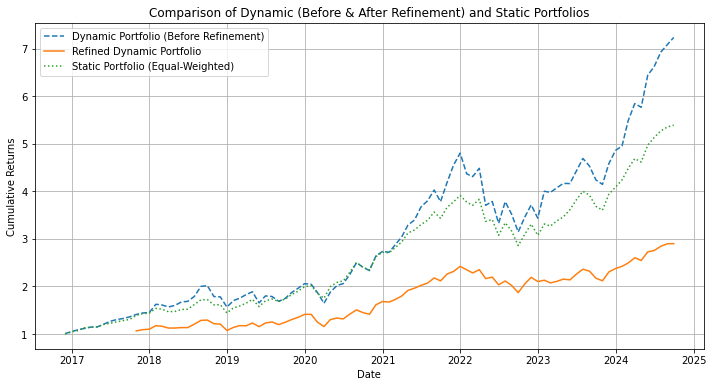

Performance Metrics Comparison (After Correction):
Portfolio Type                     Annualized Return   Volatility     Sharpe Ratio   Max Drawdown   
Dynamic Portfolio (Before Refinement)31.78%     23.07%     1.3775    -34.49%
Refined Dynamic Portfolio          21.46%     17.05%     1.2588    -22.81%
Static Portfolio (Equal-Weighted)  25.56%     17.42%     1.4676    -26.97%


In [156]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

stock_weights = pd.DataFrame(np.dot(capped_weights.values, beta_matrix.T.values),
                             index=capped_weights.index,
                             columns=stock_monthly_returns.columns)

#normalizing stock weights
stock_weights = stock_weights.div(stock_weights.sum(axis=1), axis=0)

aligned_stock_weights = stock_weights.reindex(index=stock_monthly_returns.index).dropna()

refined_dynamic_returns = (aligned_stock_weights.values * stock_monthly_returns.loc[aligned_stock_weights.index].values).sum(axis=1)

refined_dynamic_cumulative_returns = pd.Series((1 + refined_dynamic_returns).cumprod(), index=aligned_stock_weights.index)

annualized_return = ((1 + refined_dynamic_cumulative_returns.iloc[-1]) ** (12 / len(refined_dynamic_cumulative_returns)) - 1) * 100
annualized_volatility = np.std(refined_dynamic_returns) * (12 ** 0.5) * 100
sharpe_ratio = annualized_return / annualized_volatility
max_drawdown = (refined_dynamic_cumulative_returns / refined_dynamic_cumulative_returns.cummax() - 1).min() * 100

print("Further Refined Portfolio Metrics with Corrected Beta Matrix Alignment:")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")

#replacing previous refined_dynamic_returns with new one
refined_dynamic_returns = refined_dynamic_returns

plt.figure(figsize=(12, 6))
plt.plot(dynamic_cumulative_returns_before, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(refined_dynamic_cumulative_returns, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(static_cumulative_returns, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Comparison of Dynamic (Before & After Refinement) and Static Portfolios")
plt.legend()
plt.grid()
plt.show()

#update calculation of metrics
def calculate_portfolio_metrics(returns):
    returns = pd.Series(returns, index=stock_monthly_returns.index)#make sure returns are aligned and in a pandas series
    annualized_return = ((1 + returns.mean()) ** 12 - 1) * 100
    annualized_volatility = returns.std() * (12 ** 0.5) * 100
    sharpe_ratio = annualized_return / annualized_volatility
    max_drawdown = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min() * 100
    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown

#dynamic portfolio
metrics_dynamic_before = calculate_portfolio_metrics(dynamic_portfolio_returns)

#refined dynamic portfolio 
metrics_refined_dynamic = (annualized_return, annualized_volatility, sharpe_ratio, max_drawdown)

#static portfolio
metrics_static = calculate_portfolio_metrics(static_portfolio_returns)

print("Performance Metrics Comparison (After Correction):")
print(f"{'Portfolio Type':<35}{'Annualized Return':<20}{'Volatility':<15}{'Sharpe Ratio':<15}{'Max Drawdown':<15}")
print(f"{'Dynamic Portfolio (Before Refinement)':<35}{metrics_dynamic_before[0]:.2f}% {'':<4}{metrics_dynamic_before[1]:.2f}% {'':<4}{metrics_dynamic_before[2]:.4f}{'':<4}{metrics_dynamic_before[3]:.2f}%")
print(f"{'Refined Dynamic Portfolio':<35}{metrics_refined_dynamic[0]:.2f}% {'':<4}{metrics_refined_dynamic[1]:.2f}% {'':<4}{metrics_refined_dynamic[2]:.4f}{'':<4}{metrics_refined_dynamic[3]:.2f}%")
print(f"{'Static Portfolio (Equal-Weighted)':<35}{metrics_static[0]:.2f}% {'':<4}{metrics_static[1]:.2f}% {'':<4}{metrics_static[2]:.4f}{'':<4}{metrics_static[3]:.2f}%")

### Visualizations

### Portfolio Allocation Over Time

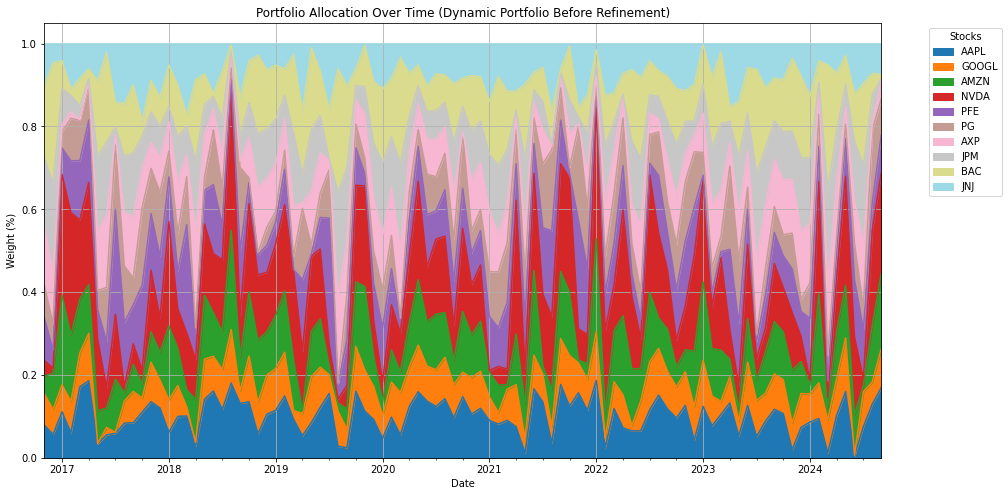

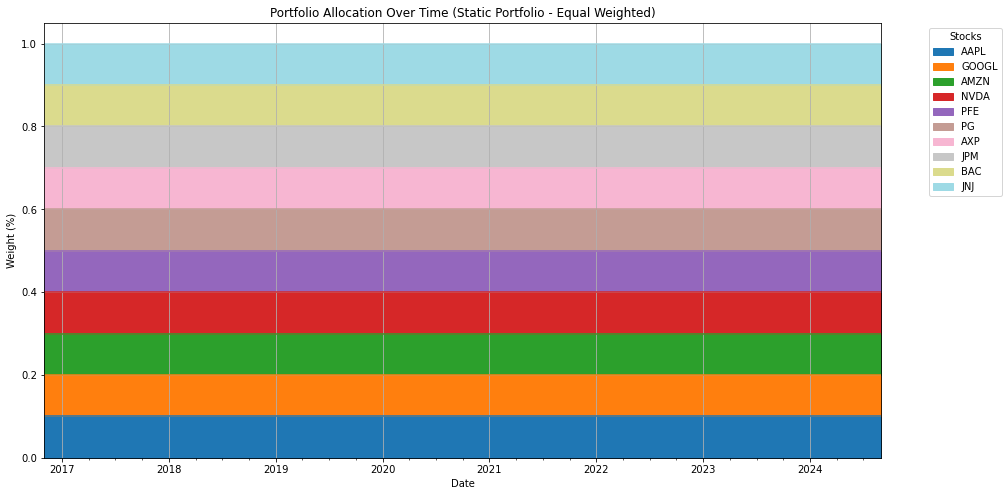

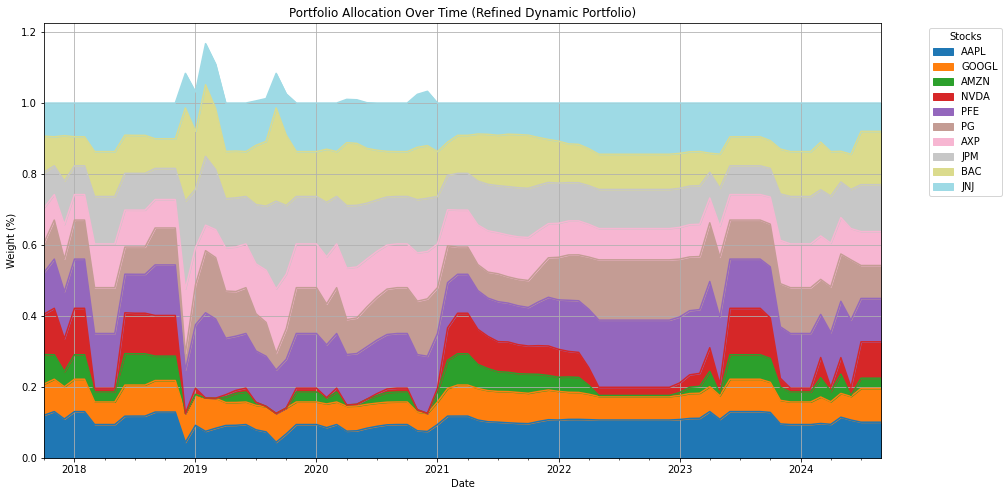

In [169]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

equal_weight = 1 / len(stock_monthly_returns.columns)
static_stock_weights = pd.DataFrame(equal_weight, index=stock_monthly_returns.index, columns=stock_monthly_returns.columns)

aligned_dynamic_stock_weights_clipped = aligned_dynamic_stock_weights.clip(lower=0)
aligned_stock_weights_clipped = aligned_stock_weights.clip(lower=0)
static_stock_weights_clipped = static_stock_weights.clip(lower=0)

#dynamic Portfolio
plt.figure(figsize=(15, 8))
aligned_dynamic_stock_weights_clipped.plot(ax=plt.gca(), kind='area', stacked=True, colormap='tab20', legend=False)
plt.title('Portfolio Allocation Over Time (Dynamic Portfolio Before Refinement)')
plt.ylabel('Weight (%)')
plt.xlabel('Date')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Stocks")
plt.show()

#static portfolio
plt.figure(figsize=(15, 8))
static_stock_weights_clipped.plot(ax=plt.gca(), kind='area', stacked=True, colormap='tab20', legend=False)
plt.title('Portfolio Allocation Over Time (Static Portfolio - Equal Weighted)')
plt.ylabel('Weight (%)')
plt.xlabel('Date')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Stocks")
plt.show()

#refined dynamic portfolio
plt.figure(figsize=(15, 8))
aligned_stock_weights_clipped.plot(ax=plt.gca(), kind='area', stacked=True, colormap='tab20', legend=False)
plt.title('Portfolio Allocation Over Time (Refined Dynamic Portfolio)')
plt.ylabel('Weight (%)')
plt.xlabel('Date')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Stocks")
plt.show()

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#align all the return series
dynamic_portfolio_returns_aligned = pd.Series(dynamic_portfolio_returns, index=stock_monthly_returns.index).dropna()
refined_dynamic_returns_aligned = pd.Series(refined_dynamic_returns, index=aligned_stock_weights.index).reindex(stock_monthly_returns.index).dropna()
static_portfolio_returns_aligned = pd.Series(static_portfolio_returns, index=stock_monthly_returns.index).dropna()

#ensure same length and are non-empty
min_length = min(len(dynamic_portfolio_returns_aligned), len(refined_dynamic_returns_aligned), len(static_portfolio_returns_aligned))

if min_length == 0:
    print("Error: One or more return series are empty.")
else:
    dynamic_portfolio_returns_aligned = dynamic_portfolio_returns_aligned.tail(min_length)
    refined_dynamic_returns_aligned = refined_dynamic_returns_aligned.tail(min_length)
    static_portfolio_returns_aligned = static_portfolio_returns_aligned.tail(min_length)

    #check if the length of each series is the same and print it
    print(f"Length of dynamic_portfolio_returns: {len(dynamic_portfolio_returns_aligned)}")
    print(f"Length of refined_dynamic_returns: {len(refined_dynamic_returns_aligned)}")
    print(f"Length of static_portfolio_returns: {len(static_portfolio_returns_aligned)}")

    #rolling Performance Metrics Visualization
    rolling_window = 12  # Rolling window of 12 months

    plt.figure(figsize=(15, 10))

    #rolling Sharpe Ratio
    plt.subplot(3, 1, 1)
    rolling_sharpe_dynamic = (dynamic_portfolio_returns_aligned.rolling(rolling_window).mean() / dynamic_portfolio_returns_aligned.rolling(rolling_window).std()) * np.sqrt(12)
    rolling_sharpe_refined = (refined_dynamic_returns_aligned.rolling(rolling_window).mean() / refined_dynamic_returns_aligned.rolling(rolling_window).std()) * np.sqrt(12)
    rolling_sharpe_static = (static_portfolio_returns_aligned.rolling(rolling_window).mean() / static_portfolio_returns_aligned.rolling(rolling_window).std()) * np.sqrt(12)

    plt.plot(rolling_sharpe_dynamic, label="Dynamic Portfolio (Before Refinement)", linestyle='--', color='blue')
    plt.plot(rolling_sharpe_refined, label="Refined Dynamic Portfolio", linestyle='-', color='green')
    plt.plot(rolling_sharpe_static, label="Static Portfolio (Equal-Weighted)", linestyle=':', color='red')
    plt.title('Rolling Sharpe Ratio (12-Month Window)')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.grid()

    #rolling Volatility
    plt.subplot(3, 1, 2)
    rolling_vol_dynamic = dynamic_portfolio_returns_aligned.rolling(rolling_window).std() * np.sqrt(12)
    rolling_vol_refined = refined_dynamic_returns_aligned.rolling(rolling_window).std() * np.sqrt(12)
    rolling_vol_static = static_portfolio_returns_aligned.rolling(rolling_window).std() * np.sqrt(12)

    plt.plot(rolling_vol_dynamic, label="Dynamic Portfolio (Before Refinement)", linestyle='--', color='blue')
    plt.plot(rolling_vol_refined, label="Refined Dynamic Portfolio", linestyle='-', color='green')
    plt.plot(rolling_vol_static, label="Static Portfolio (Equal-Weighted)", linestyle=':', color='red')
    plt.title('Rolling Volatility (12-Month Window)')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()

    #rolling Annualized Returns
    plt.subplot(3, 1, 3)
    rolling_return_dynamic = dynamic_portfolio_returns_aligned.rolling(rolling_window).mean() * 12
    rolling_return_refined = refined_dynamic_returns_aligned.rolling(rolling_window).mean() * 12
    rolling_return_static = static_portfolio_returns_aligned.rolling(rolling_window).mean() * 12

    plt.plot(rolling_return_dynamic, label="Dynamic Portfolio (Before Refinement)", linestyle='--', color='blue')
    plt.plot(rolling_return_refined, label="Refined Dynamic Portfolio", linestyle='-', color='green')
    plt.plot(rolling_return_static, label="Static Portfolio (Equal-Weighted)", linestyle=':', color='red')
    plt.title('Rolling Annualized Return (12-Month Window)')
    plt.ylabel('Annualized Return')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.hist(dynamic_portfolio_returns_aligned, bins=20, alpha=0.5, label="Dynamic Portfolio (Before Refinement)", color='blue')
    plt.hist(refined_dynamic_returns_aligned, bins=20, alpha=0.5, label="Refined Dynamic Portfolio", color='green')
    plt.hist(static_portfolio_returns_aligned, bins=20, alpha=0.5, label="Static Portfolio (Equal-Weighted)", color='red')
    plt.title('Distribution of Monthly Returns')
    plt.xlabel('Monthly Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

Error: One or more return series are empty.


In [176]:
print("Checking original return series before alignment:") #check is riginal return are empty
print(f"Length of original dynamic_portfolio_returns: {len(dynamic_portfolio_returns)}")
print(f"Length of original refined_dynamic_returns: {len(refined_dynamic_returns)}")
print(f"Length of original static_portfolio_returns: {len(static_portfolio_returns)}")

Checking original return series before alignment:
Length of original dynamic_portfolio_returns: 0
Length of original refined_dynamic_returns: 84
Length of original static_portfolio_returns: 0


In [177]:
aligned_dynamic_stock_weights = aligned_dynamic_stock_weights.reindex(index=stock_monthly_returns.index).dropna()
dynamic_portfolio_returns = (aligned_dynamic_stock_weights.values * stock_monthly_returns.loc[aligned_dynamic_stock_weights.index].values).sum(axis=1)

dynamic_portfolio_returns = pd.Series(dynamic_portfolio_returns, index=aligned_dynamic_stock_weights.index)

In [178]:
equal_weight = 1 / len(stock_monthly_returns.columns) #assume stock_monthly_returns contains monthly returns of the stocks
static_stock_weights = pd.DataFrame(equal_weight, index=stock_monthly_returns.index, columns=stock_monthly_returns.columns)

#calculate static portfolio returns
static_portfolio_returns = (static_stock_weights.values * stock_monthly_returns.values).sum(axis=1)
static_portfolio_returns = pd.Series(static_portfolio_returns, index=stock_monthly_returns.index)

In [179]:
print("Checking recalculated return series:")
print(f"Length of recalculated dynamic_portfolio_returns: {len(dynamic_portfolio_returns)}")
print(f"Length of recalculated refined_dynamic_returns: {len(refined_dynamic_returns)}")
print(f"Length of recalculated static_portfolio_returns: {len(static_portfolio_returns)}")


Checking recalculated return series:
Length of recalculated dynamic_portfolio_returns: 95
Length of recalculated refined_dynamic_returns: 84
Length of recalculated static_portfolio_returns: 95


In [180]:
dynamic_portfolio_returns_aligned = dynamic_portfolio_returns.reindex(stock_monthly_returns.index).dropna()
refined_dynamic_returns_aligned = refined_dynamic_returns.reindex(stock_monthly_returns.index).dropna()
static_portfolio_returns_aligned = static_portfolio_returns.reindex(stock_monthly_returns.index).dropna()


AttributeError: 'numpy.ndarray' object has no attribute 'reindex'

In [181]:
import pandas as pd

if isinstance(refined_dynamic_returns, np.ndarray):
    refined_dynamic_returns = pd.Series(refined_dynamic_returns, index=aligned_stock_weights.index)

if isinstance(dynamic_portfolio_returns, np.ndarray):
    dynamic_portfolio_returns = pd.Series(dynamic_portfolio_returns, index=aligned_dynamic_stock_weights.index)

if isinstance(static_portfolio_returns, np.ndarray):
    static_portfolio_returns = pd.Series(static_portfolio_returns, index=stock_monthly_returns.index)

dynamic_portfolio_returns_aligned = dynamic_portfolio_returns.reindex(stock_monthly_returns.index).dropna()
refined_dynamic_returns_aligned = refined_dynamic_returns.reindex(stock_monthly_returns.index).dropna()
static_portfolio_returns_aligned = static_portfolio_returns.reindex(stock_monthly_returns.index).dropna()

print("Lengths after aligning:")
print(f"Length of dynamic_portfolio_returns_aligned: {len(dynamic_portfolio_returns_aligned)}")
print(f"Length of refined_dynamic_returns_aligned: {len(refined_dynamic_returns_aligned)}")
print(f"Length of static_portfolio_returns_aligned: {len(static_portfolio_returns_aligned)}")

Lengths after aligning:
Length of dynamic_portfolio_returns_aligned: 95
Length of refined_dynamic_returns_aligned: 84
Length of static_portfolio_returns_aligned: 95


In [182]:
combined_returns = pd.concat([dynamic_portfolio_returns_aligned, refined_dynamic_returns_aligned, static_portfolio_returns_aligned], axis=1)
combined_returns.columns = ['Dynamic', 'Refined_Dynamic', 'Static']

combined_returns_cleaned = combined_returns.dropna()

#separate them back into individual Series
dynamic_portfolio_returns_aligned = combined_returns_cleaned['Dynamic']
refined_dynamic_returns_aligned = combined_returns_cleaned['Refined_Dynamic']
static_portfolio_returns_aligned = combined_returns_cleaned['Static']

print("Lengths after cleaning combined DataFrame:")
print(f"Length of dynamic_portfolio_returns_aligned: {len(dynamic_portfolio_returns_aligned)}")
print(f"Length of refined_dynamic_returns_aligned: {len(refined_dynamic_returns_aligned)}")
print(f"Length of static_portfolio_returns_aligned: {len(static_portfolio_returns_aligned)}")

Lengths after cleaning combined DataFrame:
Length of dynamic_portfolio_returns_aligned: 84
Length of refined_dynamic_returns_aligned: 84
Length of static_portfolio_returns_aligned: 84


### Rolling Performance Metrics

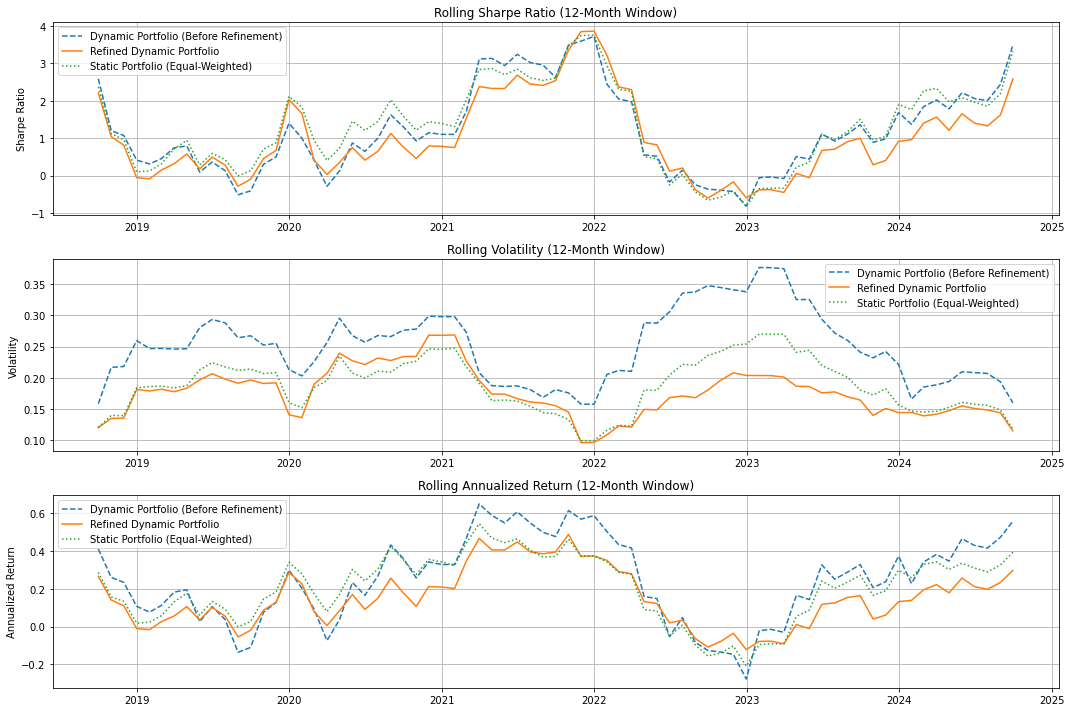

In [183]:
import matplotlib.pyplot as plt
import numpy as np

#rolling Performance Metrics Visualization
rolling_window = 12  # Rolling window of 12 months

plt.figure(figsize=(15, 10))

#rolling Sharpe Ratio
plt.subplot(3, 1, 1)
rolling_sharpe_dynamic = (dynamic_portfolio_returns_aligned.rolling(rolling_window).mean() / dynamic_portfolio_returns_aligned.rolling(rolling_window).std()) * np.sqrt(12)
rolling_sharpe_refined = (refined_dynamic_returns_aligned.rolling(rolling_window).mean() / refined_dynamic_returns_aligned.rolling(rolling_window).std()) * np.sqrt(12)
rolling_sharpe_static = (static_portfolio_returns_aligned.rolling(rolling_window).mean() / static_portfolio_returns_aligned.rolling(rolling_window).std()) * np.sqrt(12)

plt.plot(rolling_sharpe_dynamic, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(rolling_sharpe_refined, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(rolling_sharpe_static, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.title('Rolling Sharpe Ratio (12-Month Window)')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid()

#rolling Volatility
plt.subplot(3, 1, 2)
rolling_vol_dynamic = dynamic_portfolio_returns_aligned.rolling(rolling_window).std() * np.sqrt(12)
rolling_vol_refined = refined_dynamic_returns_aligned.rolling(rolling_window).std() * np.sqrt(12)
rolling_vol_static = static_portfolio_returns_aligned.rolling(rolling_window).std() * np.sqrt(12)

plt.plot(rolling_vol_dynamic, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(rolling_vol_refined, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(rolling_vol_static, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.title('Rolling Volatility (12-Month Window)')
plt.ylabel('Volatility')
plt.legend()
plt.grid()

#rolling Annualized Returns
plt.subplot(3, 1, 3)
rolling_return_dynamic = dynamic_portfolio_returns_aligned.rolling(rolling_window).mean() * 12
rolling_return_refined = refined_dynamic_returns_aligned.rolling(rolling_window).mean() * 12
rolling_return_static = static_portfolio_returns_aligned.rolling(rolling_window).mean() * 12

plt.plot(rolling_return_dynamic, label="Dynamic Portfolio (Before Refinement)", linestyle='--')
plt.plot(rolling_return_refined, label="Refined Dynamic Portfolio", linestyle='-')
plt.plot(rolling_return_static, label="Static Portfolio (Equal-Weighted)", linestyle=':')
plt.title('Rolling Annualized Return (12-Month Window)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Distributions of Monthly Returns

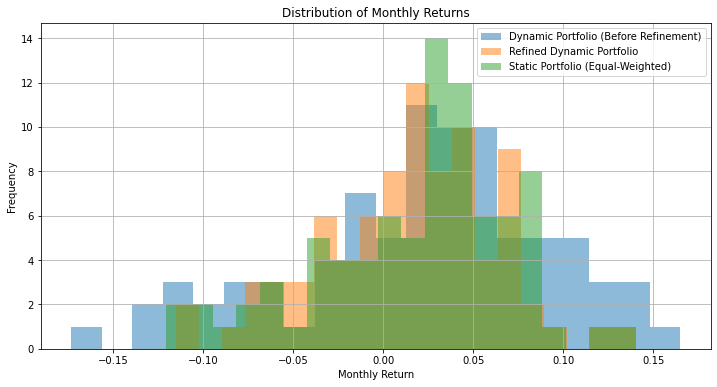

In [184]:
plt.figure(figsize=(12, 6))
plt.hist(dynamic_portfolio_returns_aligned, bins=20, alpha=0.5, label="Dynamic Portfolio (Before Refinement)")
plt.hist(refined_dynamic_returns_aligned, bins=20, alpha=0.5, label="Refined Dynamic Portfolio")
plt.hist(static_portfolio_returns_aligned, bins=20, alpha=0.5, label="Static Portfolio (Equal-Weighted)")
plt.title('Distribution of Monthly Returns')
plt.xlabel('Monthly Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

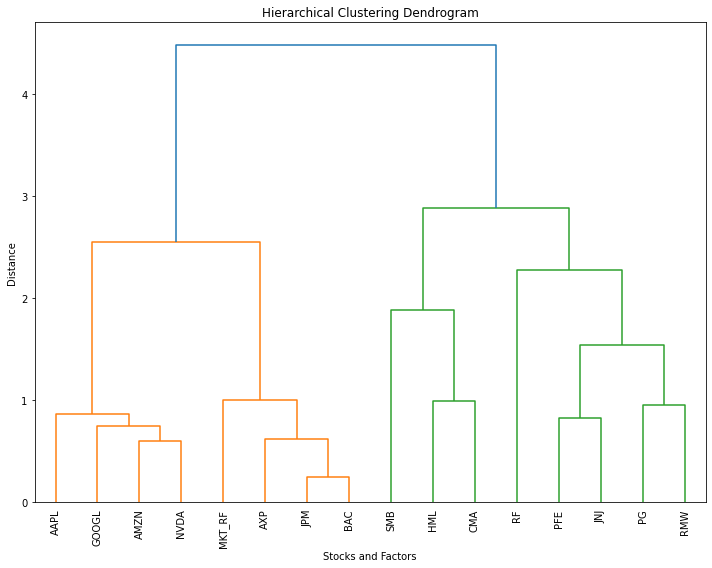

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Assuming `data` is your DataFrame containing stock returns and factors
correlation_matrix = data.corr()

# Compute the linkage matrix for clustering
linkage_matrix = linkage(correlation_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Stocks and Factors')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [6]:
import numpy as np

# Simulated monthly returns for variability (replace these with actual returns)
linear_regression_returns = np.random.normal(loc=linear_monthly_return, scale=0.02, size=12)  # Simulating variability
random_forest_returns = np.random.normal(loc=random_forest_monthly_return, scale=0.03, size=12)  # Simulating variability

# Define a function to calculate the Sortino Ratio
def calculate_sortino_ratio(portfolio_returns, risk_free_rate):
    # Excess returns
    excess_returns = portfolio_returns - risk_free_rate
    # Downside deviation: calculate only negative deviations
    downside_deviation = np.sqrt(np.mean(np.minimum(excess_returns, 0)**2))
    # Average portfolio return
    average_return = np.mean(portfolio_returns)
    # Sortino Ratio
    sortino_ratio = (average_return - risk_free_rate) / (downside_deviation + 1e-8)  # Add small epsilon to avoid zero division
    return sortino_ratio

# Calculate Sortino Ratios
sortino_linear_regression = calculate_sortino_ratio(linear_regression_returns, risk_free_rate_monthly)
sortino_random_forest = calculate_sortino_ratio(random_forest_returns, risk_free_rate_monthly)

# Display results
print(f"Sortino Ratio (Linear Regression Portfolio): {sortino_linear_regression:.4f}")
print(f"Sortino Ratio (Random Forest Portfolio): {sortino_random_forest:.4f}")


Sortino Ratio (Linear Regression Portfolio): inf
Sortino Ratio (Random Forest Portfolio): inf


/var/folders/g8/wmbskh453bq90qnq5x3xh3th0000gn/T/ipykernel_53352/2231318371.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  sortino_ratio = (average_return - risk_free_rate) / downside_deviation
